# Практическое задание №8. GAN


1.   Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

2.    Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на
курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?



## Обучение VAE на fashion_mnist

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import matplotlib.pyplot as plt

### Реализация функции оценки нормального распределения (метрики дивергенции) Кульбака-Лейблера

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Реализация вариационного авто-энкодера
> Инкапсулировал полную реализацию в одном классе.

In [13]:
class VAE(keras.Model):
    def __init__(self, latent_dim=2, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        sampling = Sampling()
        self.encoder=self.build_encoder(sampling)
        self.decoder=self.build_decoder()

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            # todo to parameter
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def build_encoder(self, sampling):
        encoder_inputs = keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = sampling([z_mean, z_log_var])
        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        return encoder

    def build_decoder(self):
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
        x = layers.Reshape((7, 7, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        return decoder

    def get_decoder(self):
        return self.decoder

    def get_encoder(self):
        return self.encoder


### Загрузка и масштабирование данных

In [38]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_clothes = np.concatenate([x_train, x_test], axis=0)
mnist_clothes = np.expand_dims(mnist_clothes, -1).astype("float32") / 255

### Сборка энкодера. Проверка слоев

In [15]:
vae = VAE()
print(vae.get_encoder().summary())
print(vae.get_decoder().summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

### I. Обучение энкодера (100 эпох)

>Обучение проводил сразу на большом количестве эпох

In [16]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='kl_loss', min_delta=0.001, verbose=1)
vae.compile(optimizer=keras.optimizers.Adam())
history=vae.fit(mnist_clothes, epochs=100, batch_size=128)

Epoch 1/100
547/547 [==============================] - 6s 9ms/step - loss: 316.1975 - reconstruction_loss: 311.5102 - kl_loss: 4.6872
Epoch 2/100
547/547 [==============================] - 5s 9ms/step - loss: 272.6300 - reconstruction_loss: 268.6666 - kl_loss: 3.9634
Epoch 3/100
547/547 [==============================] - 5s 9ms/step - loss: 268.2596 - reconstruction_loss: 264.5162 - kl_loss: 3.7435
Epoch 4/100
547/547 [==============================] - 5s 9ms/step - loss: 266.2996 - reconstruction_loss: 262.6436 - kl_loss: 3.6561
Epoch 5/100
547/547 [==============================] - 5s 9ms/step - loss: 265.1133 - reconstruction_loss: 261.4766 - kl_loss: 3.6368
Epoch 6/100
547/547 [==============================] - 5s 9ms/step - loss: 264.0544 - reconstruction_loss: 260.4489 - kl_loss: 3.6055
Epoch 7/100
547/547 [==============================] - 5s 9ms/step - loss: 263.3141 - reconstruction_loss: 259.7120 - kl_loss: 3.6021
Epoch 8/100
547/547 [==============================] - 5s 9ms/

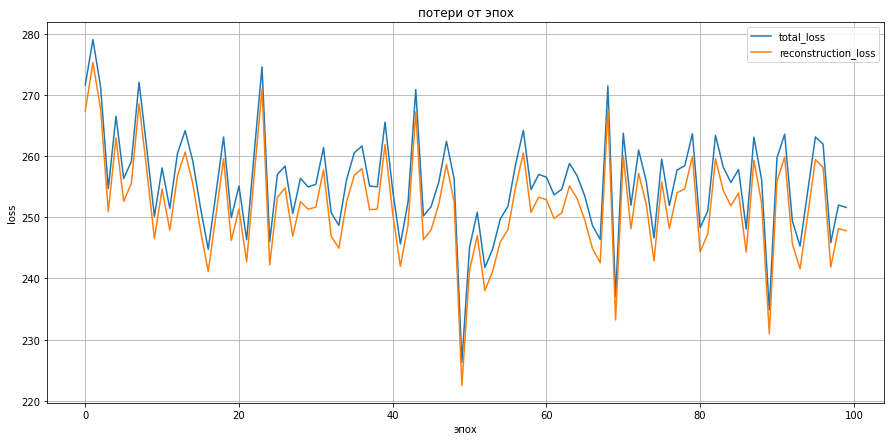

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='total_loss')
plt.plot(history.history['reconstruction_loss'], label='reconstruction_loss')
# plt.plot(history.history['kl_loss'], label='kl_loss')

plt.xlabel('эпох')
plt.ylabel('loss')
plt.legend()
plt.grid('On')
plt.title('потери от эпох')
plt.show()

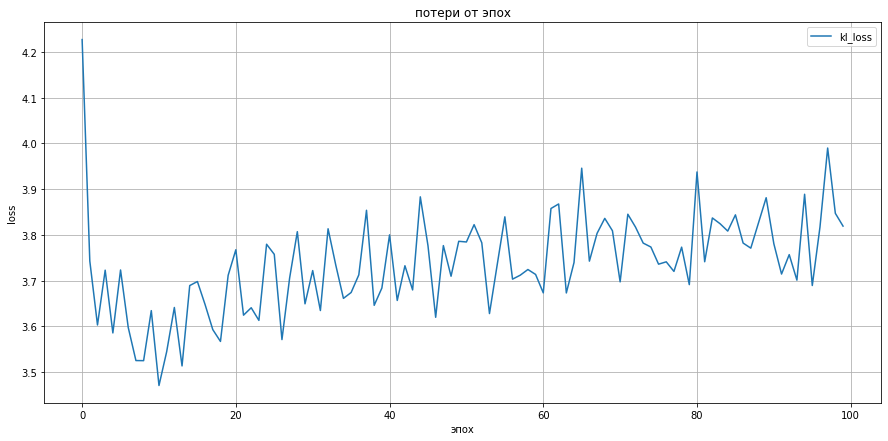

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['kl_loss'], label='kl_loss')

plt.xlabel('эпох')
plt.ylabel('loss')
plt.legend()
plt.grid('On')
plt.title('потери от эпох')
plt.show()

### Вывод
> графики показывают слабую обучаемость. Также масштабы reconstruction_loss и k_loss отличаются на порядок. Возможно необходимо применить коэффициент. По совокупности анализа (правило локтя для k_loss) принимаем что для обучения достаточно 20 эпох. Результаты показывают что это не так.

### Результат предсказания для элемента одежды

In [21]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


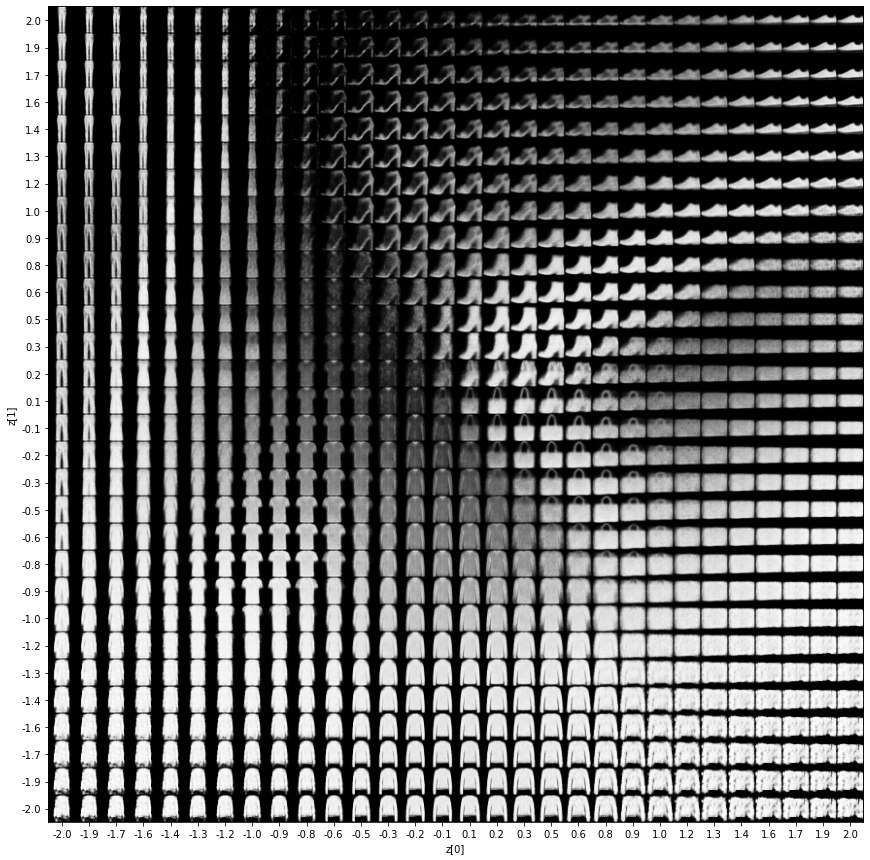

In [22]:

plot_latent(vae.get_encoder(), vae.get_decoder())


### Анализ кластеров в скрытом пространстве для элементов одежды

In [23]:

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


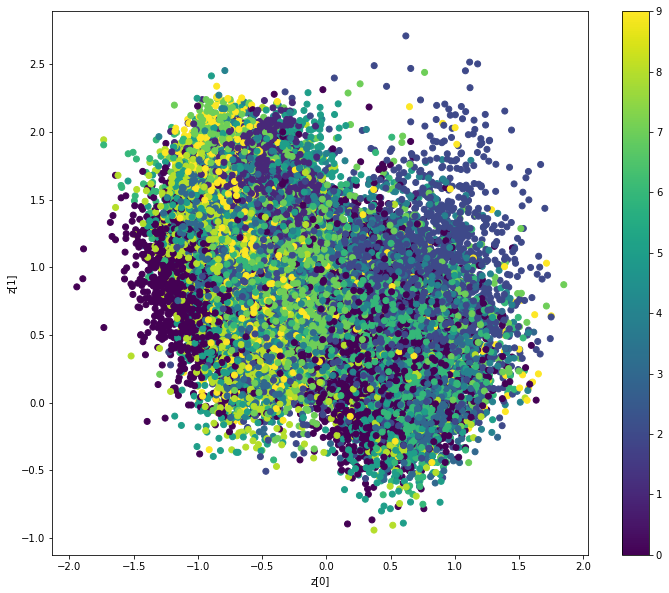

In [25]:

plot_label_clusters(vae.get_encoder(), x_train, y_train)


0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot

### Вывод
> Кластеры не явно выражены возможно модель переобучена и переходы сильно сглажены. В дальнейшем будет видно что это не так.

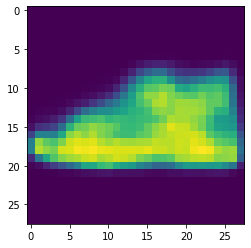

In [31]:
x_decoded = vae.get_decoder().predict([[1, 1.5]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

### II. Обучение энкодера (20 эпох)

In [34]:
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
history=vae.fit(mnist_clothes, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 5s 9ms/step - loss: 332.8775 - reconstruction_loss: 327.4837 - kl_loss: 5.3938
Epoch 2/20
547/547 [==============================] - 5s 8ms/step - loss: 276.7526 - reconstruction_loss: 271.5445 - kl_loss: 5.2081
Epoch 3/20
547/547 [==============================] - 5s 8ms/step - loss: 271.1134 - reconstruction_loss: 266.5352 - kl_loss: 4.5781
Epoch 4/20
547/547 [==============================] - 5s 8ms/step - loss: 269.1628 - reconstruction_loss: 264.6878 - kl_loss: 4.4750
Epoch 5/20
547/547 [==============================] - 5s 9ms/step - loss: 267.8625 - reconstruction_loss: 263.4061 - kl_loss: 4.4564
Epoch 6/20
547/547 [==============================] - 5s 9ms/step - loss: 266.7535 - reconstruction_loss: 262.3317 - kl_loss: 4.4218
Epoch 7/20
547/547 [==============================] - 5s 9ms/step - loss: 266.0485 - reconstruction_loss: 261.6364 - kl_loss: 4.4121
Epoch 8/20
547/547 [==============================] - 5s 9ms/step - l

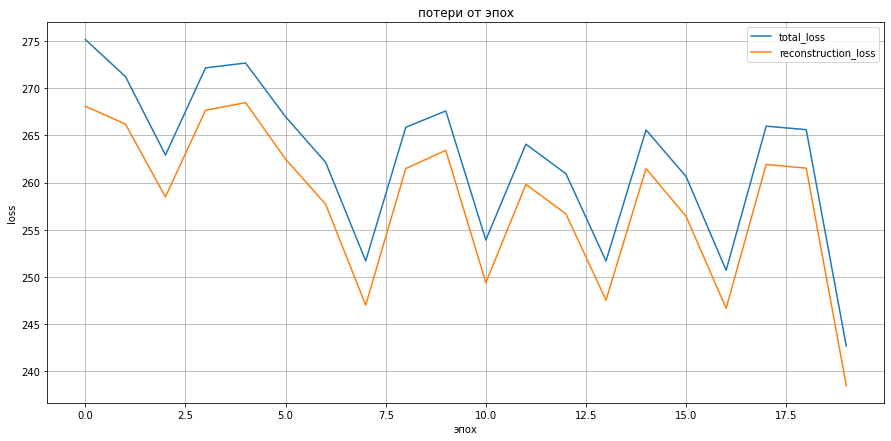

In [35]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='total_loss')
plt.plot(history.history['reconstruction_loss'], label='reconstruction_loss')

plt.xlabel('эпох')
plt.ylabel('loss')
plt.legend()
plt.grid('On')
plt.title('потери от эпох')
plt.show()

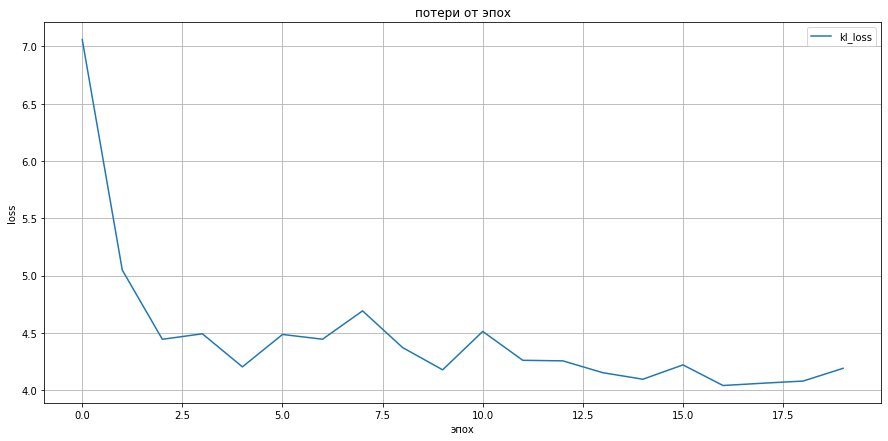

In [36]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['kl_loss'], label='kl_loss')

plt.xlabel('эпох')
plt.ylabel('loss')
plt.legend()
plt.grid('On')
plt.title('потери от эпох')
plt.show()

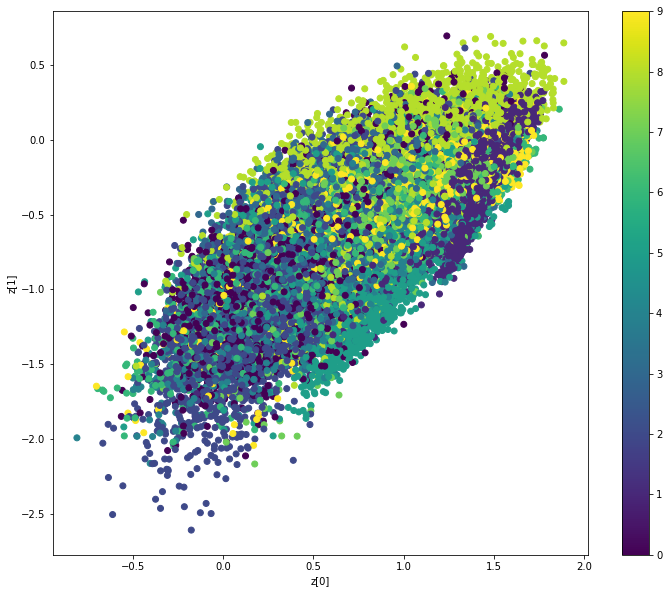

In [42]:

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(vae.get_encoder(), x_train, y_train)


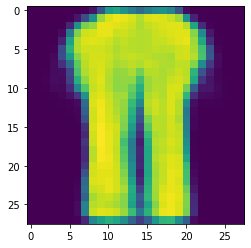

In [43]:
x_decoded = vae.get_decoder().predict([[1, 1.5]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

### Вывод
> Кластеры так и удалось сделать явно выделенными. Возможно необходимо более длительное обучение (больше 100?!). Непосредственно обученный энкодер успешно генерирует виды элементов одежды даже в двухмерном пространстве.

## Краткий обзор PathNet
  Проведите анализ:
    - Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур?
    - чем плюсы и минусы данной архитектуры?
    - Какие могут возникнуть трудности при применении данной архитектуры на практике?


**PathNet** ([https://arxiv.org/abs/1701.08734]()) — это новая архитектура модульного глубокого обучения (Modular Deep Learning),  которая демонстрирует последние тенденции в области исследований к слиянию Modular Deep Learning, Meta-Learning и Reinforcement Learning для получения более совершенных DL систем.

В отличие от более традиционных монолитных DL сетей, PathNet многократно использует сеть, которая состоит из множества нейронных сетей, и обучает их для выполнения различных задач. В своих экспериментах авторы показали, что на второй задаче сеть обучается быстрее, чем если бы она обучалась с нуля. Это указывает на то, что переносимое обучение (transfer learning, повторное использование знаний) может быть использовано в этом типе сетей. PathNet включает в себя аспекты переноса обучения, непрерывного обучения и обучения в многозадачном режиме. Это аспекты, которые необходимы для более непрерывно адаптирующейся сети и, это тот подход, который может привести к сильному искусственному интеллекту (теоретически).

![](examine-the-architecture.jpg)

Архитектура продолжает идеи:
- дополнительных API GoogLeNet.
![](GoogLeNet.jpg)
- Предзагрузки тяжелых, уже обученных сетей, с последующей адаптацией на предметную область. Например, загружаем ImageNet с весами и дообучаем только выходные дополнительные слои.

PathNet состоит из слоев нейронных сетей, где связи между сетями в слое обнаруживаются с помощью  поиска. На приведенном выше рисунке конфигурации ограничены так, чтоб выбирается не более 4-х сети на один слой за раз. В статье используются два алгоритма обучения, один на основе генетического (эволюционного) алгоритма, и второй на основе A3C обучения с подкреплением.